In [2]:
%matplotlib inline

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs, make_classification
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from tqdm import tqdm
import pandas as pd
import numpy as np

plt.style.use('ggplot')
seed = 13

Load the banana dataset.

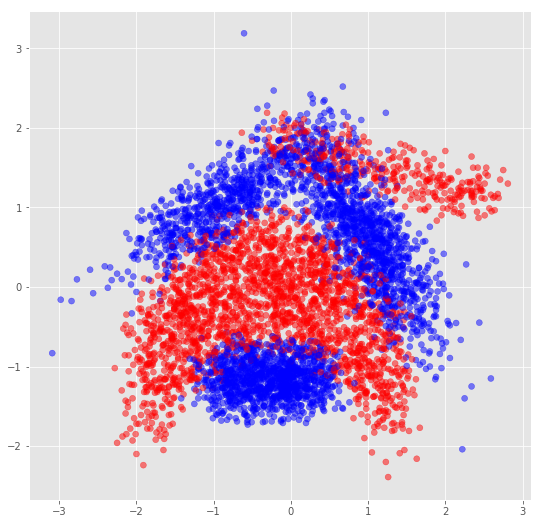

In [18]:
df = pd.read_csv('banana.csv')
X = df[['At1', 'At2']].values
y = df['Class'].map({-1:0, 1:1}).values

plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.5)
plt.show()

In [13]:
def get_ncar(y, noise_size=0.1):   
    # create an index for sampling
    idx = np.arange(y.shape[0])
    
    # pick samples to flip (no replacment!)
    idx_noise = np.random.choice(idx, size=int(noise_size*idx.shape[0]), replace=False)
    
    # flip each label to a new label
    classes = np.unique(y)
    y_ncar = y.copy()
    for i in idx_noise:
        y_ncar[i] = np.random.choice(classes[classes!=y[i]])
    return y_ncar
    

def get_nar(y, noise_size=0.1, R01=2, R10=1):
    # get scaling factors to account for class imbalance
    S0 = np.sum(y!=0)
    S1 = np.sum(y!=1)
    
    # create an index for sampling
    idx = np.arange(y.shape[0])
    
    # create normalized sampling probabilities
    p = np.ones(shape=idx.shape)
    p[y==0] = R01*S0
    p[y==1] = R10*S1
    p = normalize(p[:,np.newaxis], norm='l1', axis=0).ravel()
    
    # pick samples to flip (no replacement!)
    idx_noise = np.random.choice(idx, size=int(noise_size*idx.shape[0]), replace=False, p=p)
    
    # flip labels
    classes = np.unique(y)
    y_nar = y.copy()
    label_map = {0:1, 1:0}
    for i in idx_noise:
        sub = classes[classes!=y[i]]
        y_nar[i] = np.random.choice(sub)        
    return y_nar

def get_nnar(X, y, rounds=2, thresh=0.5, class_rank=[(0,[1,2]),(1,[2])]):
    '''
    Returns noisy not at random labels.
    
    Note: class_rank is a list of tuples. The first element in the tuple
    is the 'majority' class and the second element is the list of classes
    that are subject to flip to the 'majority'. Each tuple is applied in
    order.
    
    Example: class_rank=[(0,[1,2]),(1,[2])]
    1) Instances labeled class 1 or class 2 are subject to flip to class 0.
    2) Instances labeled class 2 are subject to flip to class 1.
    
    '''
    nn = NearestNeighbors(n_neighbors=10).fit(X,y)
    dist, ind = nn.kneighbors(X)
    
    y_nnar = y.copy()
    for j in range(1,rounds+1):
        for pair in class_rank:
            mask = np.random.uniform(size=y_nnar.shape[0])
            for i, val in enumerate(y_nnar):
                if (y_nnar[i] == pair[0]) & (y_nnar[ind[i,j]] in pair[1]) & (mask[i] > thresh):
                    y_nnar[ind[i,j]] = pair[0]
    return y_nnar

Get baseline performance.

In [19]:
acc = []
for i in tqdm(range(5000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=i)
    clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(np.mean(y_test == y_pred))
acc = np.array(acc)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:40<00:00, 122.68it/s]


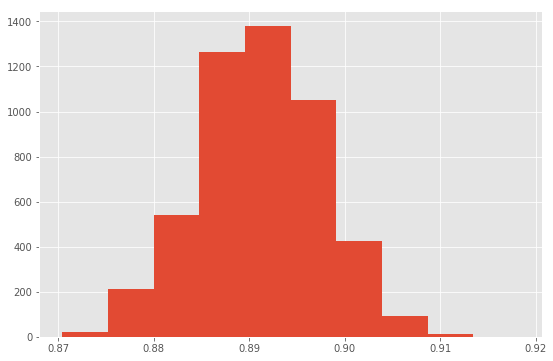

In [23]:
plt.figure(figsize=(9,6))
plt.hist(acc)
plt.show()

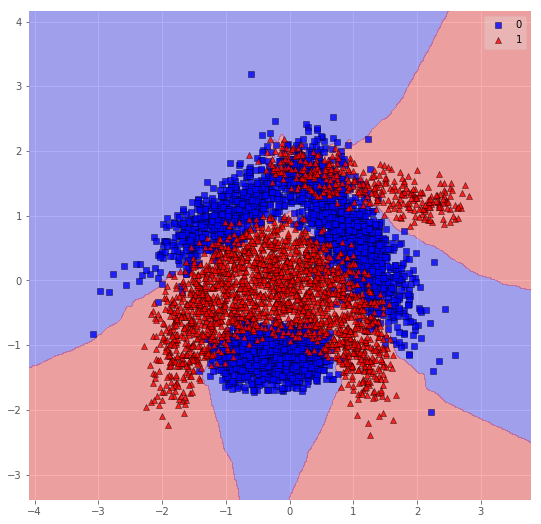

In [24]:
plt.figure(figsize=(9,9))
plot_decision_regions(X, y, clf, colors='blue,red', legend='best')
plt.show()

Label noise _completely at random_ (NCAR).

In [25]:
y_ncar = get_ncar(y, noise_size=0.1)
idx = (y != y_ncar)

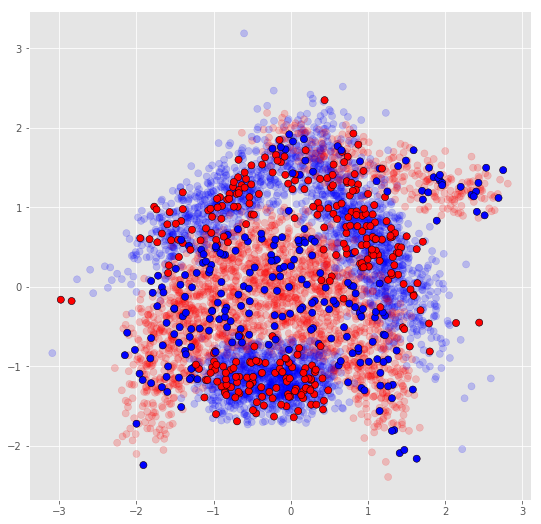

In [26]:
plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.2, s=50)
plt.scatter(X[idx,0], X[idx,1], c=y_ncar[idx], cmap='bwr', s=50, edgecolors='black')
plt.show()

In [27]:
acc_ncar, acc_ncar_true = [], []
threshold = 0.1
for i in tqdm(range(5000)):
    # Generate random labels
    y_ncar = get_ncar(y, noise_size=0.1)
    # Random train/test split
    idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_ncar, random_state=i)
    # Train model
    clf = KNeighborsClassifier(n_neighbors=5).fit(X[idx_train], y_ncar[idx_train])
    # Generate predictions and calculate performance
    y_pred = clf.predict(X[idx_test])
    acc_ncar.append(np.mean(y_ncar[idx_test] == y_pred))
    acc_ncar_true.append(np.mean(y[idx_test] == y_pred))
acc_ncar = np.array(acc_ncar)
acc_ncar_true = np.array(acc_ncar_true)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.68it/s]


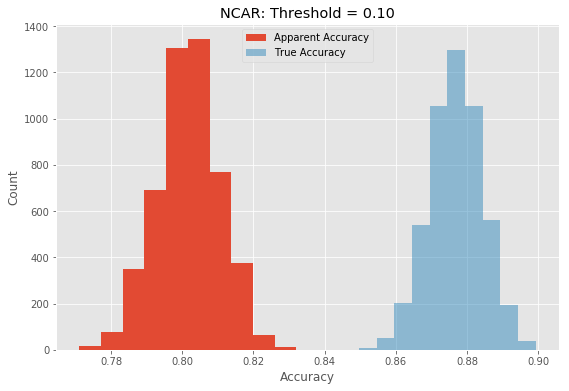

In [28]:
plt.figure(figsize=(9,6))
plt.hist(acc_ncar, label='Apparent Accuracy')
plt.hist(acc_ncar_true, label='True Accuracy', alpha=0.5)
plt.title('NCAR: Threshold = %0.2f' % threshold)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

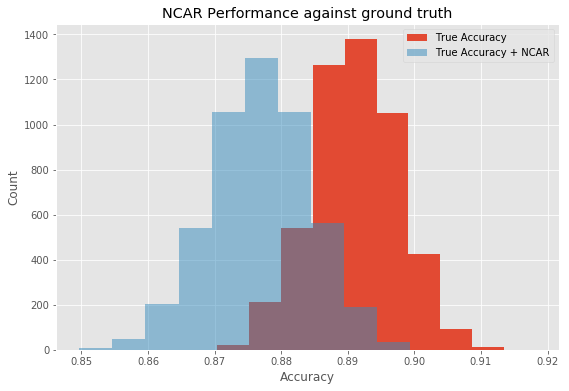

In [29]:
plt.figure(figsize=(9,6))
plt.hist(acc, label='True Accuracy')
plt.hist(acc_ncar_true, label='True Accuracy + NCAR', alpha=0.5)
plt.title('NCAR Performance against ground truth')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Try different thresholds.

In [30]:
accs_ncar = []
accs_ncar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_ncar, acc_ncar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_ncar = get_ncar(y, noise_size=threshold)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_ncar, random_state=i)
        # Train model
        clf = KNeighborsClassifier(n_neighbors=5).fit(X[idx_train], y_ncar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_ncar.append(np.mean(y_ncar[idx_test] == y_pred))
        acc_ncar_true.append(np.mean(y[idx_test] == y_pred))
    accs_ncar.append(np.percentile(acc_ncar, [2.5, 50, 97.5]))
    accs_ncar_true.append(np.percentile(acc_ncar_true, [2.5, 50, 97.5]))
accs_ncar = np.array(accs_ncar)
accs_ncar_true = np.array(accs_ncar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 176.52it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 167.33it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 161.93it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 161.38it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 157.11it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 152.51it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 147.25it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 142.98it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 141.65it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 136.66it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.61it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 131.41it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.39it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 126.44it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:40<00:00, 124.17it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 120.67it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 118.43it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 115.74it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 114.04it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 112.46it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 109.38it/s]


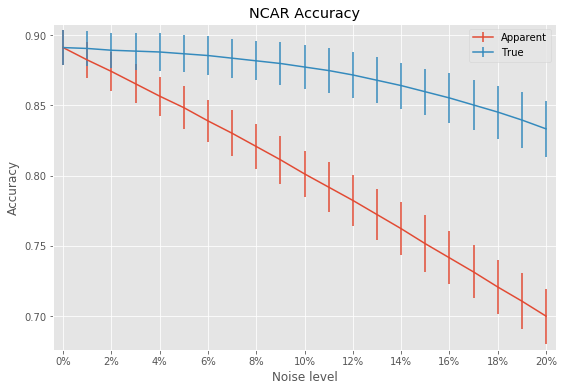

In [31]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_ncar[:,1], accs_ncar[:,1] - accs_ncar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_ncar_true[:,1], accs_ncar_true[:,1] - accs_ncar_true[:,0], label='True')
plt.title('NCAR Accuracy')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

Label noise that occurs _at random_ (NAR).

In [32]:
y_nar = get_nar(y, noise_size=0.1)
idx = (y!=y_nar)

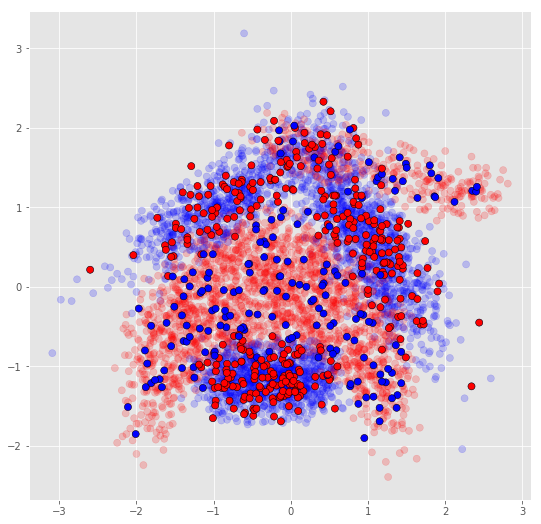

In [33]:
plt.figure(figsize=(9,9))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', alpha=0.2, s=50)
plt.scatter(X[idx,0], X[idx,1], c=y_nar[idx], cmap='bwr', s=50, edgecolors='black')
plt.show()

In [34]:
acc_nar, acc_nar_true = [], []
threshold = 0.1
for i in tqdm(range(5000)):
    # Generate random labels
    y_nar = get_nar(y, noise_size=0.1)
    # Random train/test split
    idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
    # Train model
    clf = KNeighborsClassifier(n_neighbors=5).fit(X[idx_train], y_nar[idx_train])
    # Generate predictions and calculate performance
    y_pred = clf.predict(X[idx_test])
    acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
    acc_nar_true.append(np.mean(y[idx_test] == y_pred))
acc_nar = np.array(acc_nar)
acc_nar_true = np.array(acc_nar_true)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.70it/s]


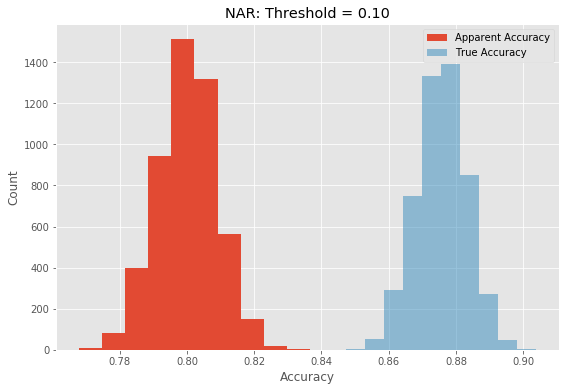

In [35]:
plt.figure(figsize=(9,6))
plt.hist(acc_nar, label='Apparent Accuracy')
plt.hist(acc_nar_true, label='True Accuracy', alpha=0.5)
plt.title('NAR: Threshold = %0.2f' % threshold)
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

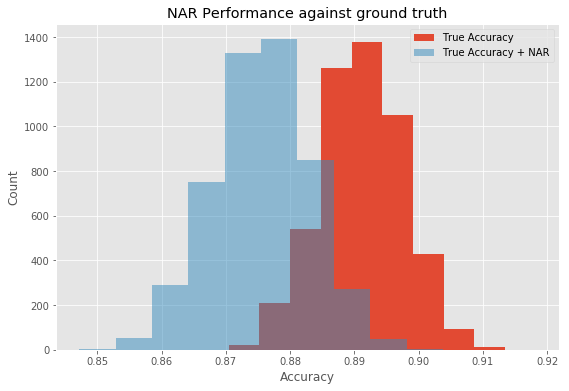

In [36]:
plt.figure(figsize=(9,6))
plt.hist(acc, label='True Accuracy')
plt.hist(acc_nar_true, label='True Accuracy + NAR', alpha=0.5)
plt.title('NAR Performance against ground truth')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

Try different thresholds.

In [38]:
accs_nar = []
accs_nar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_nar, acc_nar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_nar = get_nar(y, noise_size=threshold, R01=1, R10=1)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
        # Train model
        clf = KNeighborsClassifier(n_neighbors=5).fit(X[idx_train], y_nar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
        acc_nar_true.append(np.mean(y[idx_test] == y_pred))
    accs_nar.append(np.percentile(acc_nar, [2.5, 50.0, 97.5]))
    accs_nar_true.append(np.percentile(acc_nar_true, [2.5, 50.0, 97.5]))
accs_nar = np.array(accs_nar)
accs_nar_true = np.array(accs_nar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 172.34it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 165.74it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 162.20it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 157.20it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 153.20it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 148.55it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.16it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 140.98it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.65it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 133.66it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 130.80it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 127.85it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:40<00:00, 124.70it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 121.52it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 119.50it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 116.25it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 114.89it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 111.19it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 110.12it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 107.25it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.29it/s]


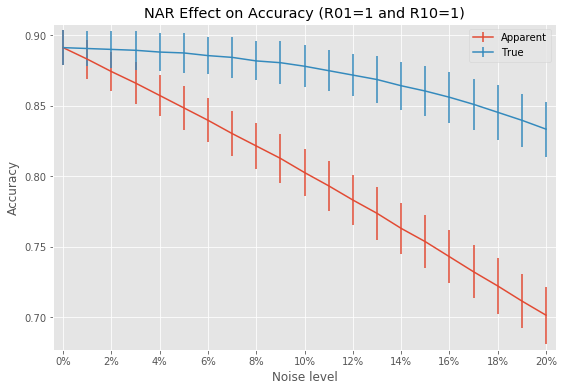

In [39]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_nar[:,1], accs_nar[:,1] - accs_nar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_nar_true[:,1], accs_nar_true[:,1] - accs_nar_true[:,0], label='True')
plt.title('NAR Effect on Accuracy (R01=1 and R10=1)')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

In [40]:
accs_nar = []
accs_nar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_nar, acc_nar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_nar = get_nar(y, noise_size=threshold, R01=2, R10=1)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
        # Train model
        clf = KNeighborsClassifier(n_neighbors=5).fit(X[idx_train], y_nar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
        acc_nar_true.append(np.mean(y[idx_test] == y_pred))
    accs_nar.append(np.percentile(acc_nar, [2.5, 50.0, 97.5]))
    accs_nar_true.append(np.percentile(acc_nar_true, [2.5, 50.0, 97.5]))
accs_nar = np.array(accs_nar)
accs_nar_true = np.array(accs_nar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 174.30it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 168.00it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 162.74it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 157.45it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 152.92it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 149.10it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.41it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 141.21it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 137.93it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.44it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 131.59it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 128.08it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 125.46it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:40<00:00, 122.49it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 118.79it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 117.04it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 114.50it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 112.35it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 110.42it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 107.62it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.76it/s]


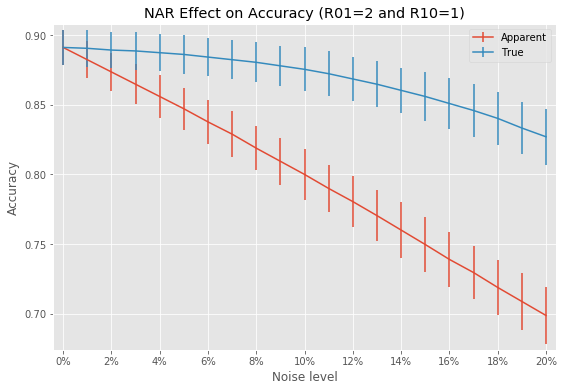

In [41]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_nar[:,1], accs_nar[:,1] - accs_nar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_nar_true[:,1], accs_nar_true[:,1] - accs_nar_true[:,0], label='True')
plt.title('NAR Effect on Accuracy (R01=2 and R10=1)')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

In [42]:
accs_nar = []
accs_nar_true = []
thresholds = np.arange(0, 0.21, 0.01)
for threshold in thresholds:
    print('Threshold = %0.2f' % threshold)
    acc_nar, acc_nar_true = [], []
    for i in tqdm(range(5000)):
        # Generate random labels
        y_nar = get_nar(y, noise_size=threshold, R01=3, R10=1)
        # Random train/test split
        idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nar, random_state=i)
        # Train model
        clf = KNeighborsClassifier(n_neighbors=5).fit(X[idx_train], y_nar[idx_train])
        # Generate predictions and calculate performance
        y_pred = clf.predict(X[idx_test])
        acc_nar.append(np.mean(y_nar[idx_test] == y_pred))
        acc_nar_true.append(np.mean(y[idx_test] == y_pred))
    accs_nar.append(np.percentile(acc_nar, [2.5, 50.0, 97.5]))
    accs_nar_true.append(np.percentile(acc_nar_true, [2.5, 50.0, 97.5]))
accs_nar = np.array(accs_nar)
accs_nar_true = np.array(accs_nar_true)

Threshold = 0.00


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 175.40it/s]


Threshold = 0.01


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 167.81it/s]


Threshold = 0.02


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 162.71it/s]


Threshold = 0.03


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 157.89it/s]


Threshold = 0.04


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:32<00:00, 153.69it/s]


Threshold = 0.05


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:33<00:00, 148.84it/s]


Threshold = 0.06


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 145.40it/s]


Threshold = 0.07


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:35<00:00, 141.66it/s]


Threshold = 0.08


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:36<00:00, 138.05it/s]


Threshold = 0.09


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.49it/s]


Threshold = 0.10


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 131.63it/s]


Threshold = 0.11


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.47it/s]


Threshold = 0.12


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 125.21it/s]


Threshold = 0.13


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:40<00:00, 122.71it/s]


Threshold = 0.14


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 120.33it/s]


Threshold = 0.15


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 117.24it/s]


Threshold = 0.16


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:43<00:00, 115.14it/s]


Threshold = 0.17


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 112.35it/s]


Threshold = 0.18


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 110.54it/s]


Threshold = 0.19


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 108.08it/s]


Threshold = 0.20


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.87it/s]


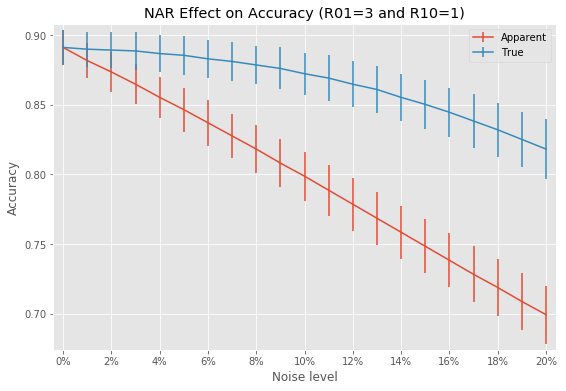

In [43]:
plt.figure(figsize=(9,6))
plt.errorbar(thresholds, accs_nar[:,1], accs_nar[:,1] - accs_nar[:,0], label='Apparent')
plt.errorbar(thresholds, accs_nar_true[:,1], accs_nar_true[:,1] - accs_nar_true[:,0], label='True')
plt.title('NAR Effect on Accuracy (R01=3 and R10=1)')
plt.xlabel('Noise level')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.xticks(thresholds[::2], ['%d%%' % val for val in np.arange(0,21)[::2]])
plt.margins(0.02)
plt.show()

Label noise _not at random_.

In [14]:
y_nnar = get_nnar(X, y, rounds=2, thresh=0.2, class_rank=[(1,[0]),])

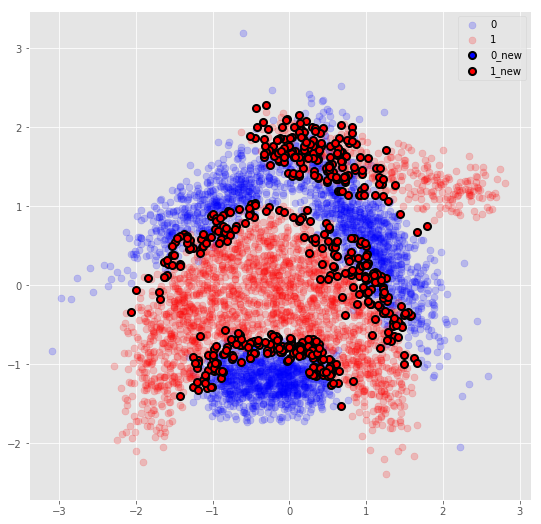

In [15]:
plt.figure(figsize=(9,9))
cmap = {0:'blue', 1:'red'}
for c in cmap.keys():
    idx = y == c
    plt.scatter(X[idx,0], X[idx,1], c=cmap[c], alpha=0.2, s=50, label=c)
for c in cmap.keys():
    idx_new = (y_nnar==c) & (y!=y_nnar)
    plt.scatter(X[idx_new,0], X[idx_new,1], c=cmap[c], edgecolor='black', lw=2, s=50, label='%d_new'%c)
plt.legend(loc='best')
plt.show()

In [16]:
acc_nnar, acc_nnar_true = [], []
threshold = 0.1
for i in tqdm(range(5000)):
    # Generate random labels
    y_nnar = get_nnar(X, y, rounds=2, thresh=0.5, class_rank=[(1,[0]),])
    # Random train/test split
    idx_train, idx_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y_nnar, random_state=i)
    # Train model
    clf = KNeighborsClassifier(n_neighbors=5).fit(X[idx_train], y_nnar[idx_train])
    # Generate predictions and calculate performance
    y_pred = clf.predict(X[idx_test])
    acc_nnar.append(np.mean(y_nnar[idx_test] == y_pred))
    acc_nnar_true.append(np.mean(y[idx_test] == y_pred))
acc_nnar = np.array(acc_nnar)
acc_nnar_true = np.array(acc_nnar_true)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:25<00:00, 18.86it/s]


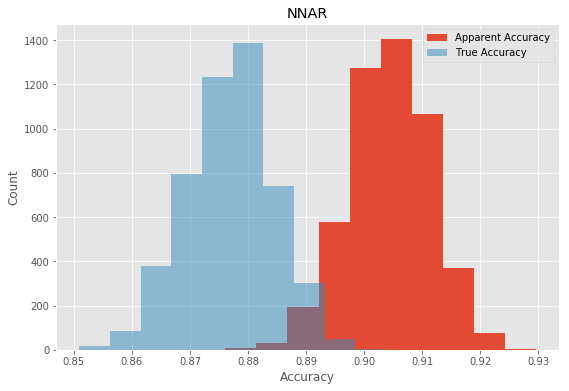

In [17]:
plt.figure(figsize=(9,6))
plt.hist(acc_nnar, label='Apparent Accuracy')
plt.hist(acc_nnar_true, label='True Accuracy', alpha=0.5)
plt.title('NNAR')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

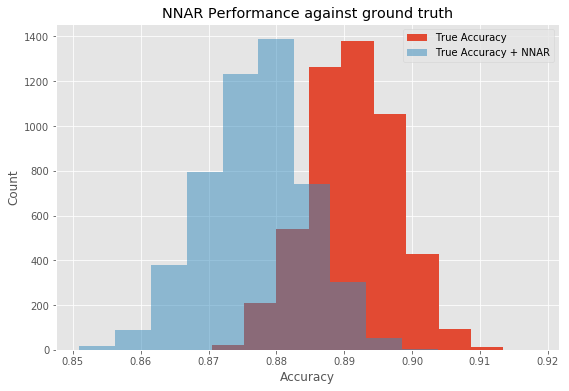

In [20]:
plt.figure(figsize=(9,6))
plt.hist(acc, label='True Accuracy')
plt.hist(acc_nnar_true, label='True Accuracy + NNAR', alpha=0.5)
plt.title('NNAR Performance against ground truth')
plt.xlabel('Accuracy')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()